# Калманов филтер - следење објекти

Очекувано време за сработување: 2 дена по 4 часа.

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('oCknzLw9LYI')

## Референци

- [Дизајнирање Калманови филтри - Роџер Лабе](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/08-Designing-Kalman-Filters.ipynb)
- [Мешање бои](https://upload.wikimedia.org/wikipedia/commons/e/eb/Subtractive-Additive-Colour-Mixing.jpg)
- [Сегментирање на слика преку праг](https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding.html)
- [Морфологија на слика](https://scikit-image.org/docs/dev/api/skimage.morphology.html)


In [1]:
import os
from collections import namedtuple
import numpy as np
import sympy as sp
import plotly.graph_objs as go

In [2]:
Gaussian = namedtuple('Gaussian', ['m', 'S'])

In [3]:
def ellipse(g, stds=[1], color=0, N=300):
    def one_ellipse(std):
        R, s, _ = np.linalg.svd(np_S)
        t = np.linspace(0, 2*np.pi, N)
        x, y = R @ np.diag(std * np.sqrt(s)) @ [np.cos(t), np.sin(t)] + np_m
        return {'x': x, 'y': y}
    
    np_m = np.array(g.m).astype(np.float64)
    np_S = np.array(g.S).astype(np.float64)
    import plotly.express as px
    colors = px.colors.qualitative.Plotly
    ellipses = [go.Scatter(one_ellipse(std), line_color=colors[color], name=color) for std in stds]
    center = go.Scatter(x=np_m[0], y=np_m[1], 
                        mode='markers', marker_size=12, marker_symbol='x', 
                        line_color=colors[color], name=color)
    return ellipses + [center]

In [4]:
def predict(g, A, B, u, R):
    m = A * g.m + B * u
    S = A * g.S * A.T + R
    return Gaussian(m, S)

In [5]:
def process_noise(var, dt):
    G = sp.Matrix([[dt**2 / 2], [dt]])
    R = G * var * G.T
    return R

In [6]:
def update(g, z, C, Q):
    Sm = C * g.S * C.T + Q
    K = g.S * C.T * Sm.inv()
    y = z - C * g.m
    m = g.m + K * y
    S = g.S - K * C * g.S
    return Gaussian(m, S)

![Летечки лимон](data/lemon/out35.png)

In [7]:
from skimage import io
from skimage import color
from skimage import exposure
from skimage import morphology

In [8]:
os.makedirs('data/lemon_black_white', exist_ok=True)
for i in range(30, 57):
    img = io.imread(f'data/lemon/out{i}.png')
    red, green, blue = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    lemon = red/2 + green/2 - blue
    lemon = (lemon > 85) * 255
    lemon = morphology.binary_opening(lemon, selem=[[1]*3]*3).astype(np.uint8)*255
    lemon = morphology.binary_opening(lemon, selem=[[1]*3]*3).astype(np.uint8)*255
    io.imsave(f'data/lemon_black_white/out{i}.png', lemon, check_contrast=False)

![Летечки лимон](data/lemon_black_white/out35.png)

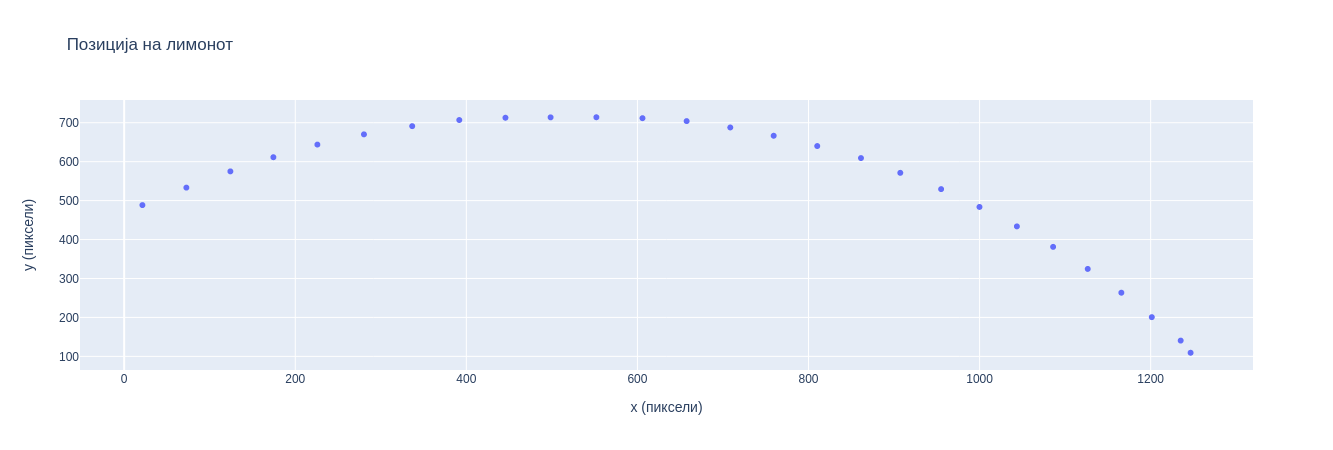

In [9]:
def get_lemon_info(i):
    img = io.imread(f'data/lemon_black_white/out{i}.png')
    img, z = morphology.label(img, background=0, return_num=True)
    lemon_label = np.argmax(np.bincount(img.ravel())[1:])
    y, x = np.nonzero(img == lemon_label+1)
    y = img.shape[0] - y
    return np.min(x), np.mean(x), np.max(x), np.min(y), np.mean(y), np.max(y)

measurement_h = [get_lemon_info(i) for i in range(30, 57)]
x_m = [d[1] for d in measurement_h]
y_m = [d[4] for d in measurement_h]

fig = go.Figure(layout_title='Позиција на лимонот', layout_xaxis_title='x (пиксели)', layout_yaxis_title='y (пиксели)')
fig.add_scatter(x=x_m, y=y_m, name='Мерења', mode='markers')
fig

## Задачи на кои треба да одговорите

1. Дизајнирајте Калманов филтер кој ќе го следи лимонот и во секој чекор ќе прави предвидување каде ќе падне лимонот.
    - Резолуцијата на сликата е 1280х720.
    - Видеото е снимано со 30 слики во секунда.
    - Совет: сметајте дека лимонот се движи во 2д простор, а не во 3д.
    - Совет: филтерот дизајнирајте го да има најмалку 4 димензии (позиција и брзина за двете просторните димензии).
        - Можете и да го дизајнирате филтерот да има 6 димензии (овојпат вклучувајќи го и забрзувањето).

## Решение

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('qMjkBnxMWbM')